# CarDheko Project - Used Car Price Prediction 

## 1. Data Merging
### Reading all the different cities with car details excel file

In [1]:
import pandas as pd
import numpy as np
import ast
import re
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats


df_bangalore = pd.read_excel("bangalore_cars.xlsx")
df_bangalore['Location']='Bangalore'

df_chennai = pd.read_excel("chennai_cars.xlsx")
df_chennai['Location']='Chennai'

df_kolkata = pd.read_excel("kolkata_cars.xlsx")
df_kolkata['Location']='Kolkata'

df_hyderabad = pd.read_excel("hyderabad_cars.xlsx")
df_hyderabad['Location']='Hyderabad'

df_delhi = pd.read_excel("delhi_cars.xlsx")
df_delhi['Location']='Delhi'

df_jaipur = pd.read_excel("jaipur_cars.xlsx")
df_jaipur['Location']='Jaipur'


### Merging all the cities into one file for further processing

In [2]:
df_concat= pd.concat([df_bangalore, df_chennai, df_kolkata, df_hyderabad, df_delhi,df_jaipur],axis = 0)
df_concat.to_excel('all_cities_cars.xlsx', index=False)

### Reading merged file

In [3]:
df = pd.read_excel("all_cities_cars.xlsx")
df.shape

(8369, 6)

In [4]:
df.head(1)

,new_car_detail,new_car_overview,new_car_feature,new_car_specs,car_links,Location
0,"{'it': 0, 'ft': 'Petrol', 'bt': 'Hatchback', '...","{'heading': 'Car overview', 'top': [{'key': 'R...","{'heading': 'Features', 'top': [{'value': 'Pow...","{'heading': 'Specifications', 'top': [{'key': ...",https://www.cardekho.com/used-car-details/used...,Bangalore


### Dropping car_links as we would not need that for our model

In [5]:
df.drop('car_links',axis=1,inplace=True)

## 2. Data Unpacking
### Unpack the data as they are in dictionaries 

In [6]:
#Checking to see type of the values in column
print(type(df['new_car_detail'].iloc[0]))
print(type(df['new_car_overview'].iloc[0]))
print(type(df['new_car_feature'].iloc[0]))
print(type(df['new_car_specs'].iloc[0]))

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [7]:
#Converting the each column to a dict as it appears as a string 
df['new_car_detail'] = df['new_car_detail'].apply(ast.literal_eval)
df['new_car_overview'] = df['new_car_overview'].apply(ast.literal_eval)
df['new_car_feature'] = df['new_car_feature'].apply(ast.literal_eval)
df['new_car_specs'] = df['new_car_specs'].apply(ast.literal_eval)

In [8]:
# Unpacking the dictionary column new_car_detail
expanded_details = pd.json_normalize(df['new_car_detail'])
expanded_details.head(1)

,it,ft,bt,km,transmission,ownerNo,owner,oem,model,modelYear,centralVariantId,variantName,price,priceActual,priceSaving,priceFixedText,trendingText.imgUrl,trendingText.heading,trendingText.desc
0,0,Petrol,Hatchback,"1,20,000",Manual,3,3rd Owner,Maruti,Maruti Celerio,2015,3979,VXI,₹ 4 Lakh,,,None,https://stimg.cardekho.com/used-cars/common/ic...,Trending Car!,High chances of sale in next 6 days


In [9]:
# Unpacking the dictionary column new_car_overview	
def process_row(row):
    top_data = {item['key']: item['value'] for item in row['top']}
    return top_data

expanded_overview = df['new_car_overview'].apply(lambda row: pd.Series(process_row(row)))

expanded_overview.head(1)

,Registration Year,Insurance Validity,Fuel Type,Seats,Kms Driven,RTO,Ownership,Engine Displacement,Transmission,Year of Manufacture
0,2015,Third Party insurance,Petrol,5 Seats,"1,20,000 Kms",KA51,Third Owner,998 cc,Manual,2015.0


In [10]:
# Unpacking the dictionary column new_car_features

def process_features(row):
    features = {}

    # Flatten 'top' values
    for item in row['top']:
        features[item['value']] = True
    
    # Flatten 'data' values
    for data_item in row.get('data', []):
        for sub_item in data_item.get('list', []):
            features[sub_item['value']] = True
    
    return features

expanded_features = df['new_car_feature'].apply(lambda row: pd.Series(process_features(row)))

expanded_features.head(1)

,Power Steering,Power Windows Front,Air Conditioner,Heater,Adjustable Head Lights,Manually Adjustable Exterior Rear View Mirror,Centeral Locking,Child Safety Locks,Power Windows Rear,Remote Trunk Opener,...,Cassette Player,Find My Car Location,Wifi Connectivity,Headlamp Washers,Real Time Vehicle Tracking,Roof Carrier,Smart Key Band,Lane Watch Camera,Removable Convertible Top,Power Folding3rd Row Seat
0,True,True,True,True,True,True,True,True,True,True,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [11]:
# Unpacking the dictionary column new_car_specs

def process_specifications(row):
    specs = {}

    # Flatten 'top' values
    for item in row['top']:
        specs[item['key']] = item['value']
    
    # Flatten 'data' values
    for data_item in row.get('data', []):
        for sub_item in data_item.get('list', []):
            specs[sub_item['key']] = sub_item['value']
    
    return specs

expanded_specs = df['new_car_specs'].apply(lambda row: pd.Series(process_specifications(row)))

expanded_specs.head(1)


,Mileage,Engine,Max Power,Torque,Seats,Color,Engine Type,Displacement,Max Torque,No of Cylinder,...,Front Brake Type,Rear Brake Type,Top Speed,Acceleration,Tyre Type,No Door Numbers,Cargo Volumn,Wheel Size,Alloy Wheel Size,Ground Clearance Unladen
0,23.1 kmpl,998 CC,67.04bhp@6000rpm,90Nm,5,White,K10B Engine,998,90Nm@3500rpm,3.0,...,Ventilated Disc,Drum,150 Kmph,15.05 Seconds,"Tubeless, Radial",5,235-litres,NaN,NaN,NaN


In [12]:
### Merge all these unpacked data columns and save it for easy fetch and process

df_expanded=pd.concat([expanded_details,expanded_overview,expanded_features,expanded_specs,df['Location']],axis=1)

df_expanded.to_excel('all_cities_cars_expanded.xlsx', index=False)


## 3. Data Processing

In [13]:
df_cars= pd.read_excel("all_cities_cars_expanded.xlsx")
df_cars.head(1)

,it,ft,bt,km,transmission,ownerNo,owner,oem,model,modelYear,...,Rear Brake Type,Top Speed,Acceleration,Tyre Type,No Door Numbers,Cargo Volumn,Wheel Size,Alloy Wheel Size,Ground Clearance Unladen,Location
0,0,Petrol,Hatchback,"1,20,000",Manual,3,3rd Owner,Maruti,Maruti Celerio,2015,...,Drum,150 Kmph,15.05 Seconds,"Tubeless, Radial",5.0,235-litres,NaN,NaN,NaN,Bangalore


In [14]:
df_cars.isna().sum()

it                             0
ft                             0
bt                             4
km                             0
transmission                   0
                            ... 
Cargo Volumn                1593
Wheel Size                  2983
Alloy Wheel Size            2983
Ground Clearance Unladen    7854
Location                       0
Length: 243, dtype: int64

In [15]:
# Dropping all columns with more than 50% missing values

threshold = len(df_cars) * 0.5
df_cars.dropna(axis=1, thresh=threshold,inplace=True)

df_cars.head(1)

,it,ft,bt,km,transmission,ownerNo,owner,oem,model,modelYear,...,Front Brake Type,Rear Brake Type,Top Speed,Acceleration,Tyre Type,No Door Numbers,Cargo Volumn,Wheel Size,Alloy Wheel Size,Location
0,0,Petrol,Hatchback,"1,20,000",Manual,3,3rd Owner,Maruti,Maruti Celerio,2015,...,Ventilated Disc,Drum,150 Kmph,15.05 Seconds,"Tubeless, Radial",5.0,235-litres,NaN,NaN,Bangalore


In [16]:
df_cars.nunique()

it                     1
ft                     5
bt                    10
km                  4090
transmission           2
                    ... 
No Door Numbers        5
Cargo Volumn         321
Wheel Size            17
Alloy Wheel Size      17
Location               6
Length: 122, dtype: int64

In [17]:
# Dropping all columns with only one unique value
df_cars = df_cars.loc[:, df_cars.nunique() > 1]
df_cars.head(1)

,ft,bt,km,transmission,ownerNo,owner,oem,model,modelYear,centralVariantId,...,Front Brake Type,Rear Brake Type,Top Speed,Acceleration,Tyre Type,No Door Numbers,Cargo Volumn,Wheel Size,Alloy Wheel Size,Location
0,Petrol,Hatchback,"1,20,000",Manual,3,3rd Owner,Maruti,Maruti Celerio,2015,3979,...,Ventilated Disc,Drum,150 Kmph,15.05 Seconds,"Tubeless, Radial",5.0,235-litres,NaN,NaN,Bangalore


In [18]:
# Expanding to see all columns fully
pd.set_option('display.max_columns', None)
df_cars.head(1)


,ft,bt,km,transmission,ownerNo,owner,oem,model,modelYear,centralVariantId,variantName,price,Registration Year,Insurance Validity,Fuel Type,Seats,Kms Driven,RTO,Ownership,Engine Displacement,Transmission,Year of Manufacture,Mileage,Engine,Max Power,Torque,Seats.1,Color,Engine Type,Displacement,Max Torque,No of Cylinder,Values per Cylinder,Value Configuration,Fuel Suppy System,Turbo Charger,Super Charger,Length,Width,Height,Wheel Base,Front Tread,Rear Tread,Kerb Weight,Gear Box,Drive Type,Seating Capacity,Steering Type,Turning Radius,Front Brake Type,Rear Brake Type,Top Speed,Acceleration,Tyre Type,No Door Numbers,Cargo Volumn,Wheel Size,Alloy Wheel Size,Location
0,Petrol,Hatchback,"1,20,000",Manual,3,3rd Owner,Maruti,Maruti Celerio,2015,3979,VXI,₹ 4 Lakh,2015,Third Party insurance,Petrol,5 Seats,"1,20,000 Kms",KA51,Third Owner,998 cc,Manual,2015.0,23.1 kmpl,998 CC,67.04bhp@6000rpm,90Nm,5.0,White,K10B Engine,998.0,90Nm@3500rpm,3.0,4.0,DOHC,MPFi,No,No,3715mm,1635mm,1565mm,2425mm,1420mm,1410mm,835kg,5 Speed,FWD,5.0,Power,4.7 metres,Ventilated Disc,Drum,150 Kmph,15.05 Seconds,"Tubeless, Radial",5.0,235-litres,NaN,NaN,Bangalore


In [19]:
# Checking for duplicate rows
df_cars.duplicated().sum()

85

In [20]:
# Dropping duplicate rows

df_cars.drop_duplicates(keep='first',inplace=True)
df_cars.duplicated().sum()

0

In [21]:
# Dropping columns that are duplicates or not required
df_cars.drop(['owner','centralVariantId','Fuel Type','Registration Year','Year of Manufacture','Engine Displacement','Transmission','Max Power','Torque','Wheel Size','Seats.1','Engine','Torque','Length','Width','Height','Wheel Base','Front Tread','Rear Tread','Kerb Weight','Values per Cylinder','Value Configuration','Seats','Turning Radius','Top Speed','Acceleration','Alloy Wheel Size','Kms Driven','Ownership','Max Torque','Cargo Volumn'],axis=1,inplace=True)
df_cars.head(1)

,ft,bt,km,transmission,ownerNo,oem,model,modelYear,variantName,price,Insurance Validity,RTO,Mileage,Color,Engine Type,Displacement,No of Cylinder,Fuel Suppy System,Turbo Charger,Super Charger,Gear Box,Drive Type,Seating Capacity,Steering Type,Front Brake Type,Rear Brake Type,Tyre Type,No Door Numbers,Location
0,Petrol,Hatchback,"1,20,000",Manual,3,Maruti,Maruti Celerio,2015,VXI,₹ 4 Lakh,Third Party insurance,KA51,23.1 kmpl,White,K10B Engine,998.0,3.0,MPFi,No,No,5 Speed,FWD,5.0,Power,Ventilated Disc,Drum,"Tubeless, Radial",5.0,Bangalore


In [22]:
# Handling string columns that are numerical

df_cars.dtypes

ft                     object
bt                     object
km                     object
transmission           object
ownerNo                 int64
oem                    object
model                  object
modelYear               int64
variantName            object
price                  object
Insurance Validity     object
RTO                    object
Mileage                object
Color                  object
Engine Type            object
Displacement          float64
No of Cylinder        float64
Fuel Suppy System      object
Turbo Charger          object
Super Charger          object
Gear Box               object
Drive Type             object
Seating Capacity      float64
Steering Type          object
Front Brake Type       object
Rear Brake Type        object
Tyre Type              object
No Door Numbers       float64
Location               object
dtype: object

In [23]:
# price 

def convert_price(price_str):
    # Remove the currency symbol and commas
    price_str = re.sub(r'[₹,]', '', price_str).strip()
    
    # Handle different units
    if 'Crore' in price_str:
        price_str = price_str.replace('Crore', '').strip()
        return float(price_str) * 10000000  # Convert to the base unit (e.g., rupees)
    elif 'Lakh' in price_str:
        price_str = price_str.replace('Lakh', '').strip()
        return float(price_str) * 100000  # Convert to the base unit (e.g., rupees)
    elif 'Thousand' in price_str:
        price_str = price_str.replace('Thousand', '').strip()
        return float(price_str) * 1000  # Convert to the base unit (e.g., rupees)
    else:
        return float(price_str)  # Assume it's already in the base unit (e.g., rupees)

# Apply the conversion function to the 'price' column
df_cars['price'] = df_cars['price'].apply(convert_price)
df_cars.head(1)

,ft,bt,km,transmission,ownerNo,oem,model,modelYear,variantName,price,Insurance Validity,RTO,Mileage,Color,Engine Type,Displacement,No of Cylinder,Fuel Suppy System,Turbo Charger,Super Charger,Gear Box,Drive Type,Seating Capacity,Steering Type,Front Brake Type,Rear Brake Type,Tyre Type,No Door Numbers,Location
0,Petrol,Hatchback,"1,20,000",Manual,3,Maruti,Maruti Celerio,2015,VXI,400000.0,Third Party insurance,KA51,23.1 kmpl,White,K10B Engine,998.0,3.0,MPFi,No,No,5 Speed,FWD,5.0,Power,Ventilated Disc,Drum,"Tubeless, Radial",5.0,Bangalore


In [24]:
# km
def convert_km(km_str):
    # Remove commas
    km_str = re.sub(r',', '', km_str).strip()
    # Convert to float
    return float(km_str)

# Apply the conversion function to the 'km' column
df_cars['km'] = df_cars['km'].apply(convert_km)
df_cars.head(1)

,ft,bt,km,transmission,ownerNo,oem,model,modelYear,variantName,price,Insurance Validity,RTO,Mileage,Color,Engine Type,Displacement,No of Cylinder,Fuel Suppy System,Turbo Charger,Super Charger,Gear Box,Drive Type,Seating Capacity,Steering Type,Front Brake Type,Rear Brake Type,Tyre Type,No Door Numbers,Location
0,Petrol,Hatchback,120000.0,Manual,3,Maruti,Maruti Celerio,2015,VXI,400000.0,Third Party insurance,KA51,23.1 kmpl,White,K10B Engine,998.0,3.0,MPFi,No,No,5 Speed,FWD,5.0,Power,Ventilated Disc,Drum,"Tubeless, Radial",5.0,Bangalore


In [25]:
# Mileage

def clean_mileage(value):
    if pd.isna(value):
        return np.nan

    value = str(value).strip().lower()

    if 'km/kg' in value:
        numeric_value = re.sub(r'[^\d.]', '', value)
        numeric_value = numeric_value.rstrip('.')
        value_float = float(numeric_value)*0.74
        return value_float

    else:
        numeric_value = re.sub(r'[^\d.]', '', value)
        numeric_value = numeric_value.rstrip('.')
        value_float = float(numeric_value)
        return value_float

df_cars['Mileage'] = df_cars['Mileage'].apply(clean_mileage)
df_cars.head(1)

,ft,bt,km,transmission,ownerNo,oem,model,modelYear,variantName,price,Insurance Validity,RTO,Mileage,Color,Engine Type,Displacement,No of Cylinder,Fuel Suppy System,Turbo Charger,Super Charger,Gear Box,Drive Type,Seating Capacity,Steering Type,Front Brake Type,Rear Brake Type,Tyre Type,No Door Numbers,Location
0,Petrol,Hatchback,120000.0,Manual,3,Maruti,Maruti Celerio,2015,VXI,400000.0,Third Party insurance,KA51,23.1,White,K10B Engine,998.0,3.0,MPFi,No,No,5 Speed,FWD,5.0,Power,Ventilated Disc,Drum,"Tubeless, Radial",5.0,Bangalore


In [26]:
df_cars.isna().sum()

ft                       0
bt                       4
km                       0
transmission             0
ownerNo                  0
oem                      0
model                    0
modelYear                0
variantName              0
price                    0
Insurance Validity       4
RTO                    874
Mileage                285
Color                    3
Engine Type            290
Displacement             4
No of Cylinder          31
Fuel Suppy System     1708
Turbo Charger         1029
Super Charger         1938
Gear Box               106
Drive Type            1540
Seating Capacity         6
Steering Type          254
Front Brake Type        96
Rear Brake Type         96
Tyre Type               77
No Door Numbers         11
Location                 0
dtype: int64

In [27]:
#filling null values in numerical columns with median
df_cars['Mileage'].fillna(df_cars['Mileage'].median(), inplace=True)
df_cars['Displacement'].fillna(df_cars['Displacement'].median(), inplace=True)
df_cars['No of Cylinder'].fillna(df_cars['No of Cylinder'].median(), inplace=True)
df_cars['Seating Capacity'].fillna(df_cars['Seating Capacity'].median(), inplace=True)
df_cars['No Door Numbers'].fillna(df_cars['Seating Capacity'].median(), inplace=True)

C:\Users\Siva\AppData\Local\Temp\ipykernel_31216\4189711864.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cars['Mileage'].fillna(df_cars['Mileage'].median(), inplace=True)
C:\Users\Siva\AppData\Local\Temp\ipykernel_31216\4189711864.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

In [28]:
df_cars.isna().sum()

ft                       0
bt                       4
km                       0
transmission             0
ownerNo                  0
oem                      0
model                    0
modelYear                0
variantName              0
price                    0
Insurance Validity       4
RTO                    874
Mileage                  0
Color                    3
Engine Type            290
Displacement             0
No of Cylinder           0
Fuel Suppy System     1708
Turbo Charger         1029
Super Charger         1938
Gear Box               106
Drive Type            1540
Seating Capacity         0
Steering Type          254
Front Brake Type        96
Rear Brake Type         96
Tyre Type               77
No Door Numbers          0
Location                 0
dtype: int64

In [29]:
# Remove outliers in the numerical columns using z-score
# Function to remove outliers using Z-score
def remove_outliers_zscore(df, columns, z_thresh=3):
        for column in columns:
        # Calculate Z-scores
            z_scores = stats.zscore(df[column])
        
        # Filter out the outliers
            df = df[(abs(z_scores) < z_thresh)]
    
        return df

# Apply the function to the DataFrame
columns_to_check = ['km','price','modelYear','Mileage','Displacement']
df_cars_zscore_outlier = remove_outliers_zscore(df_cars, columns_to_check)
df_cars_zscore_outlier.shape

(7838, 29)

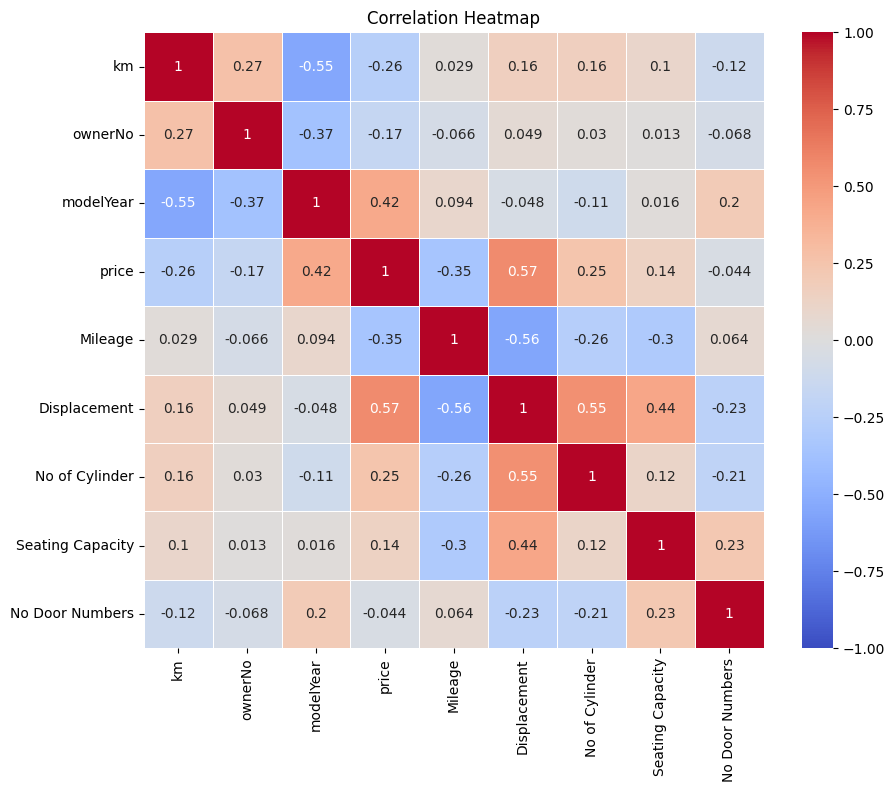

Correlation with 'price':
km                 -0.256213
ownerNo            -0.169339
modelYear           0.421369
price               1.000000
Mileage            -0.346918
Displacement        0.565857
No of Cylinder      0.245100
Seating Capacity    0.137682
No Door Numbers    -0.043681
Name: price, dtype: float64


In [30]:
# heatmap for numerical columns

numeric_df = df_cars_zscore_outlier.select_dtypes(include=[float, int])

# Calculate the correlation matrix
correlation_matrix = numeric_df.corr()

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Heatmap')
plt.show()

# Extract the correlation with 'price'
correlation_with_price = correlation_matrix['price']

# Print the correlation matrix with 'price'
print("Correlation with 'price':")
print(correlation_with_price)

C:\Users\Siva\AppData\Local\Temp\ipykernel_31216\3322647776.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=correlation_with_price.index, y=correlation_with_price.values, palette='viridis')


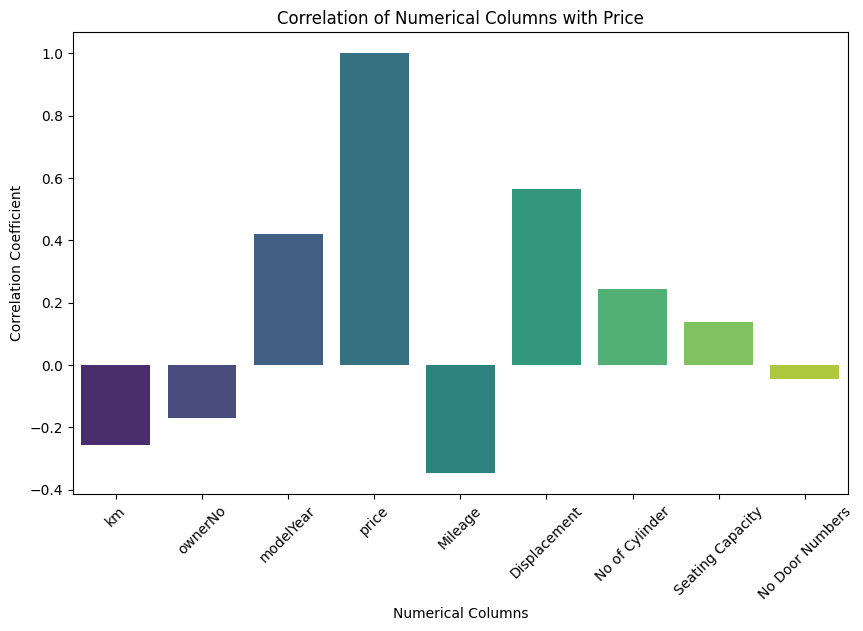

In [31]:
plt.figure(figsize=(10, 6))
sns.barplot(x=correlation_with_price.index, y=correlation_with_price.values, palette='viridis')
plt.title('Correlation of Numerical Columns with Price')
plt.xlabel('Numerical Columns')
plt.ylabel('Correlation Coefficient')
plt.xticks(rotation=45)
plt.show()

#### We can see that modelYear,engine displacement,km has a strong co-relation with price, with rest of them being close to 0, we can also drop mileage as the we can infer from car model thus we choose values > 0.25 or < -0.25

In [32]:
# dropping columns not required according to co-relation with price but can keep ownerNo as it makes sense

df_cars_zscore_outlier.drop(['Seating Capacity','No Door Numbers','No of Cylinder','ownerNo','Mileage'],axis=1, inplace=True)
df_cars_zscore_outlier.head(1)

,ft,bt,km,transmission,oem,model,modelYear,variantName,price,Insurance Validity,RTO,Color,Engine Type,Displacement,Fuel Suppy System,Turbo Charger,Super Charger,Gear Box,Drive Type,Steering Type,Front Brake Type,Rear Brake Type,Tyre Type,Location
0,Petrol,Hatchback,120000.0,Manual,Maruti,Maruti Celerio,2015,VXI,400000.0,Third Party insurance,KA51,White,K10B Engine,998.0,MPFi,No,No,5 Speed,FWD,Power,Ventilated Disc,Drum,"Tubeless, Radial",Bangalore


## Dealing with Categorical data


In [33]:
df_cars_zscore_outlier.iloc[0]

ft                                   Petrol
bt                                Hatchback
km                                 120000.0
transmission                         Manual
oem                                  Maruti
model                        Maruti Celerio
modelYear                              2015
variantName                             VXI
price                              400000.0
Insurance Validity    Third Party insurance
RTO                                    KA51
Color                                 White
Engine Type                     K10B Engine
Displacement                          998.0
Fuel Suppy System                      MPFi
Turbo Charger                            No
Super Charger                            No
Gear Box                           5 Speed 
Drive Type                              FWD
Steering Type                         Power
Front Brake Type            Ventilated Disc
Rear Brake Type                        Drum
Tyre Type                  Tubel

In [34]:
df_cars_zscore_outlier.isna().sum()

ft                       0
bt                       3
km                       0
transmission             0
oem                      0
model                    0
modelYear                0
variantName              0
price                    0
Insurance Validity       4
RTO                    823
Color                    0
Engine Type            233
Displacement             0
Fuel Suppy System     1591
Turbo Charger          957
Super Charger         1811
Gear Box                59
Drive Type            1454
Steering Type          230
Front Brake Type        61
Rear Brake Type         61
Tyre Type               54
Location                 0
dtype: int64

### RTO Location column

In [35]:
rto_group_mapping = {
    'KA': 'Karnataka',
    'HR': 'Haryana',
    'WB': 'West Bengal',
    'TN': 'Tamil Nadu',
    'UP': 'Uttar Pradesh',
    'DL': 'Delhi',
    'MH': 'Maharashtra',
    'RJ': 'Rajasthan',
    'AP': 'Andhra Pradesh',
    'GJ': 'Gujarat',
    'OR': 'Odisha',
    'PY': 'Puducherry',
    'Unknown': 'Unknown'
}

# Function to map RTO values
def map_rto(rto):
    if pd.isna(rto):
        return 'Unknown'
    rto_str = str(rto)  # Convert value to string
    for key in rto_group_mapping:
        if rto_str.startswith(key):
            return rto_group_mapping[key]
    return 'Unknown'

# Convert float values to 'Unknown'
df_cars_zscore_outlier['RTO'] = df_cars_zscore_outlier['RTO'].fillna('Unknown')

# Apply the function to the DataFrame
df_cars_zscore_outlier['RTO_grouped'] = df_cars_zscore_outlier['RTO'].apply(map_rto)
df_cars_zscore_outlier.drop('RTO',axis=1,inplace=True)
df_cars_zscore_outlier.head(1)

,ft,bt,km,transmission,oem,model,modelYear,variantName,price,Insurance Validity,Color,Engine Type,Displacement,Fuel Suppy System,Turbo Charger,Super Charger,Gear Box,Drive Type,Steering Type,Front Brake Type,Rear Brake Type,Tyre Type,Location,RTO_grouped
0,Petrol,Hatchback,120000.0,Manual,Maruti,Maruti Celerio,2015,VXI,400000.0,Third Party insurance,White,K10B Engine,998.0,MPFi,No,No,5 Speed,FWD,Power,Ventilated Disc,Drum,"Tubeless, Radial",Bangalore,Karnataka


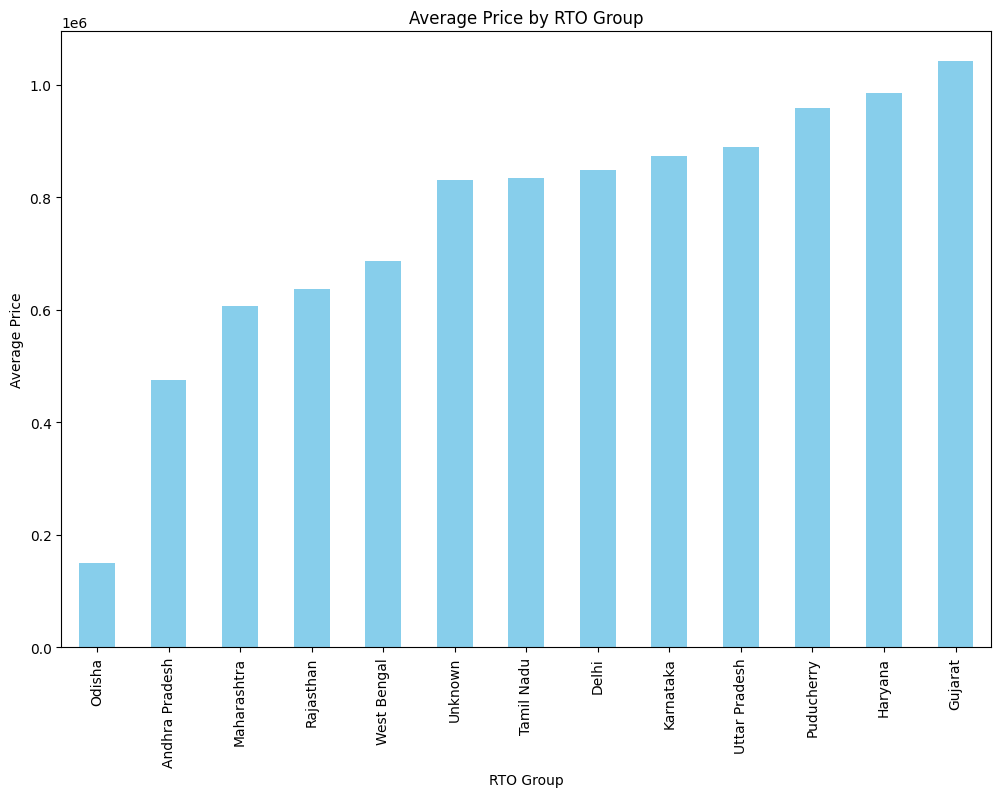

In [36]:
plt.figure(figsize=(12, 8))
average_prices = df_cars_zscore_outlier.groupby('RTO_grouped')['price'].mean().sort_values()
average_prices.plot(kind='bar', color='skyblue')
plt.xticks(rotation=90)
plt.title('Average Price by RTO Group')
plt.xlabel('RTO Group')
plt.ylabel('Average Price')
plt.show()


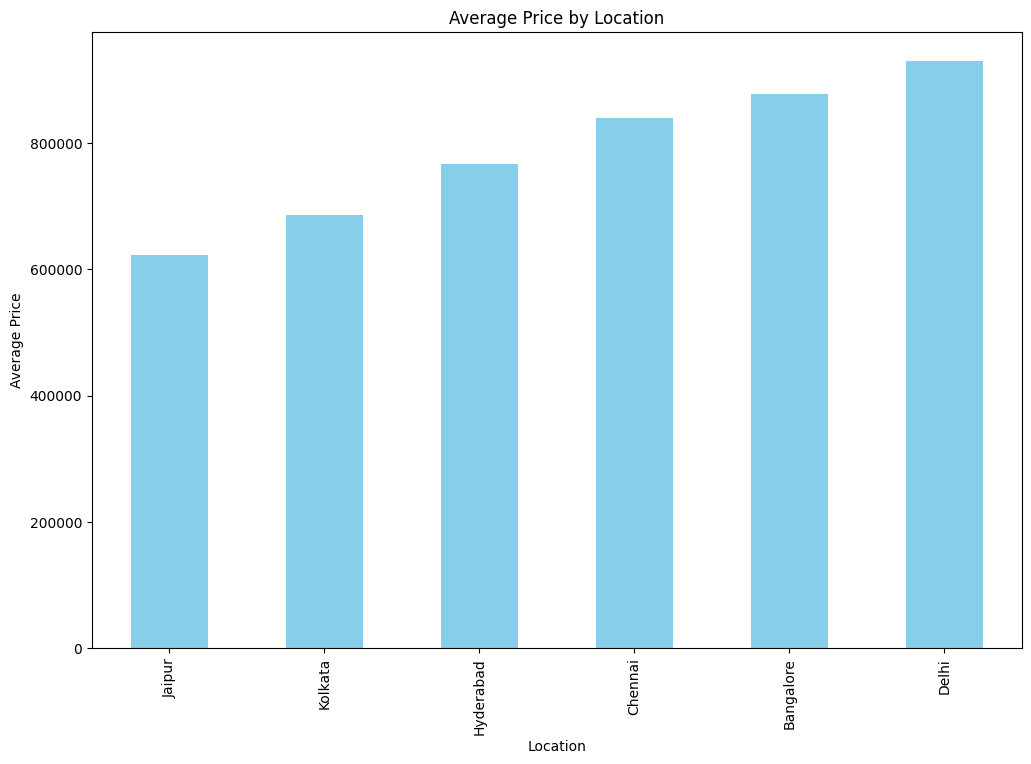

In [37]:
plt.figure(figsize=(12, 8))
average_prices = df_cars_zscore_outlier.groupby('Location')['price'].mean().sort_values()
average_prices.plot(kind='bar', color='skyblue')
plt.xticks(rotation=90)
plt.title('Average Price by Location')
plt.xlabel('Location')
plt.ylabel('Average Price')
plt.show()


### Can keep these two columns RTO_group and Location

## Color Column 

In [38]:
def determine_color(color):
    color_lower = color.lower()
    
    if 'white' in color_lower:
        return 'White'
    elif 'red' in color_lower or 'wine' in color_lower or 'cherry' in color_lower:
        return 'Red'
    elif 'blue' in color_lower:
        return 'Blue'
    elif 'brown' in color_lower:
        return 'Brown'
    elif 'gold' in color_lower:
        return 'Gold'
    elif 'green' in color_lower:
        return 'Green'
    elif 'black' in color_lower:
        return 'Black'     
    elif 'orange' in color_lower:
        return 'Orange'
    elif 'yellow' in color_lower:
        return 'Yellow'
    elif 'bronze' in color_lower:
        return 'Bronze'
    elif 'purple' in color_lower:
        return 'Purple'
    elif 'grey' in color_lower or 'gray' in color_lower:
        return 'Gray'
    elif 'silver' in color_lower or 'metal' in color_lower or 'steel' in color_lower:
        return 'Silver'
    else:
        return 'Other'  # Returns Other if no condition is met

# Apply the function to the DataFrame column
df_cars_zscore_outlier['Color'] = df_cars_zscore_outlier['Color'].apply(determine_color)
df_cars_zscore_outlier['Color'].value_counts()

Color
Other     2138
White     1552
Silver    1266
Red        806
Gray       614
Blue       577
Black      378
Brown      273
Orange     101
Gold        57
Green       42
Yellow      19
Purple      10
Bronze       5
Name: count, dtype: int64

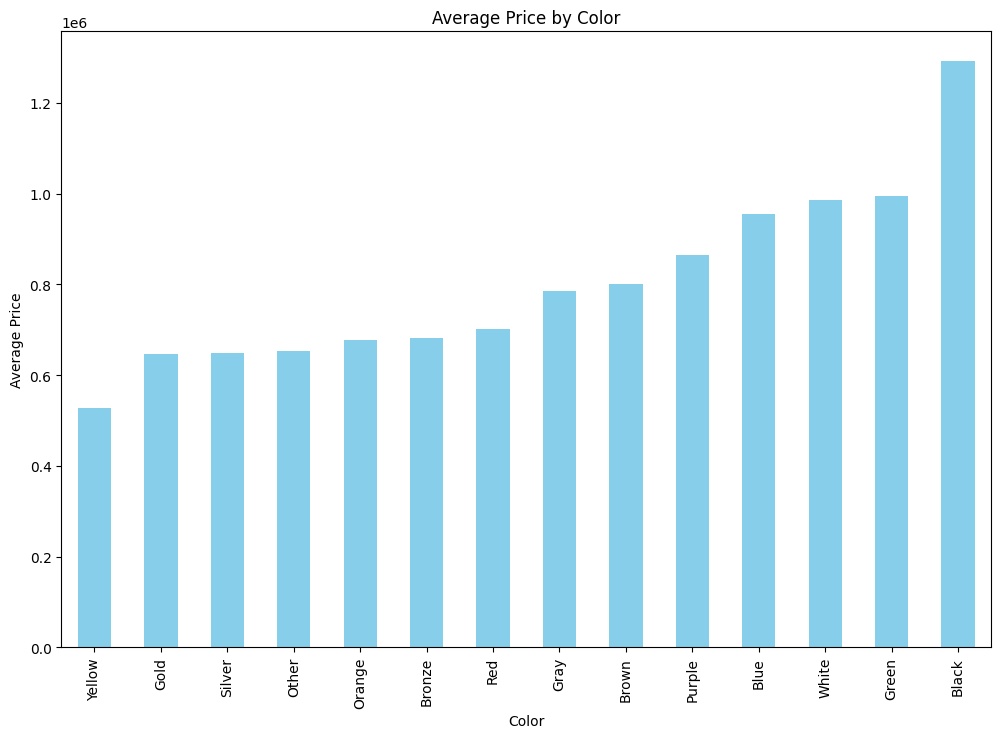

In [39]:
plt.figure(figsize=(12, 8))
average_prices = df_cars_zscore_outlier.groupby('Color')['price'].mean().sort_values()
average_prices.plot(kind='bar', color='skyblue')
plt.xticks(rotation=90)
plt.title('Average Price by Color')
plt.xlabel('Color')
plt.ylabel('Average Price')
plt.show()


### Can keep this column too as price does vary with color 

## Insurance Validity Column 


In [40]:
df_cars_zscore_outlier['Insurance Validity'].unique()

array(['Third Party insurance', 'Comprehensive', 'Third Party',
       'Zero Dep', nan, '2', '1', 'Not Available'], dtype=object)

In [41]:
df_cars_zscore_outlier['Insurance Validity']= df_cars_zscore_outlier['Insurance Validity'].replace('Third Party insurance','Third Party')

In [42]:
df_cars_zscore_outlier['Insurance Validity'].value_counts()

Insurance Validity
Third Party      4410
Comprehensive    2907
Zero Dep          297
Not Available     216
1                   3
2                   1
Name: count, dtype: int64

In [43]:
df_cars_zscore_outlier = df_cars_zscore_outlier[~df_cars_zscore_outlier['Insurance Validity'].isin(['1', '2'])]
df_cars_zscore_outlier['Insurance Validity'].fillna('Not Available', inplace=True)
df_cars_zscore_outlier['Insurance Validity'].value_counts()

C:\Users\Siva\AppData\Local\Temp\ipykernel_31216\1112464528.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_cars_zscore_outlier['Insurance Validity'].fillna('Not Available', inplace=True)


Insurance Validity
Third Party      4410
Comprehensive    2907
Zero Dep          297
Not Available     220
Name: count, dtype: int64

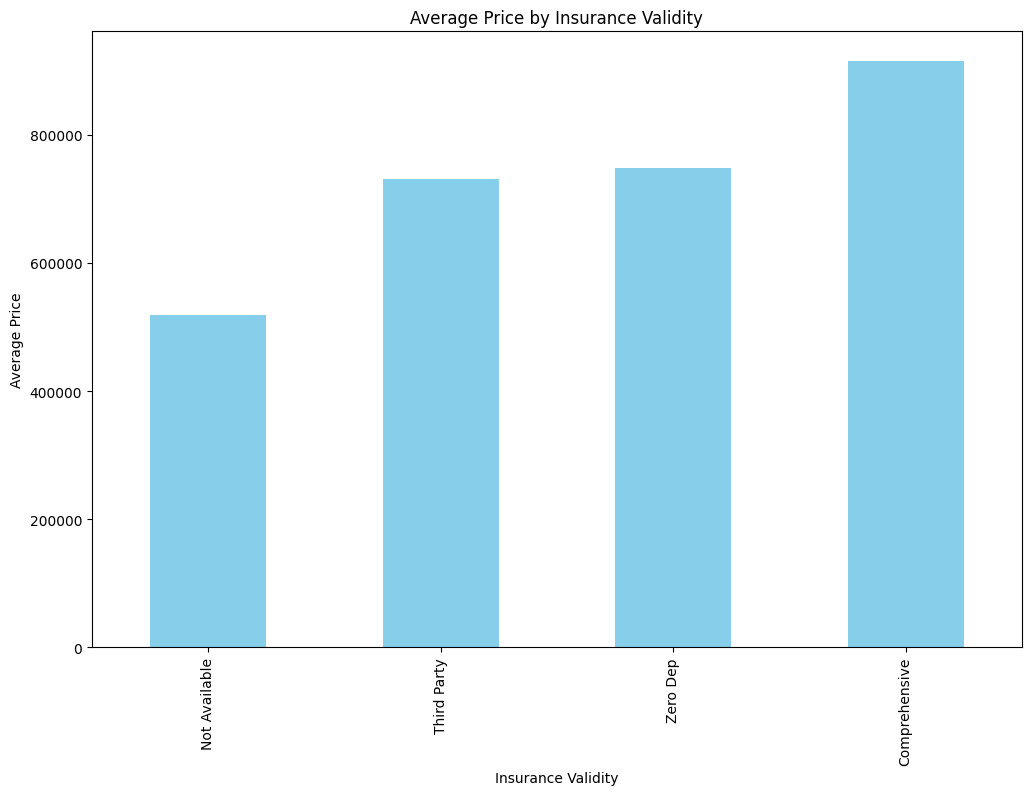

In [44]:
plt.figure(figsize=(12, 8))
average_prices = df_cars_zscore_outlier.groupby('Insurance Validity')['price'].mean().sort_values()
average_prices.plot(kind='bar', color='skyblue')
plt.xticks(rotation=90)
plt.title('Average Price by Insurance Validity')
plt.xlabel('Insurance Validity')
plt.ylabel('Average Price')
plt.show()


### Price does vary as thus we retain the Insurance Column

## Engine Type Column

In [45]:
print(df_cars_zscore_outlier['Engine Type'].head())
print(df_cars_zscore_outlier['Engine Type'].isna().sum())
print(df_cars_zscore_outlier['Engine Type'].value_counts())
df_cars_zscore_outlier.drop('Engine Type',axis=1,inplace=True)

0                 K10B Engine
1        Ti-VCT Petrol Engine
2             Revotron Engine
3    Kappa VTVT Petrol Engine
4      DDiS 200 Diesel Engine
Name: Engine Type, dtype: object
233
Engine Type
In-Line Engine              437
Kappa VTVT Petrol Engine    424
Petrol Engine               309
i-VTEC Petrol Engine        266
i VTEC Engine               199
                           ... 
2AR-FE Petrol Engine          1
 Petrol Engine                1
Smartstream G1.5 T-GDi        1
mDI CRDe Diesel Engine        1
TDI Engine                    1
Name: count, Length: 447, dtype: int64


#### We can drop this column as well as it has lots of unique values which may not overlap with car models which may reduce overall efficieny of the model, thus we can use other parameters such as fuel type, engine, or Torque if it meets the criteria

## ft and bt columns (fuel type and body type)

#### We can keep ft but can remove body type as each car model will definetly have a unique body type

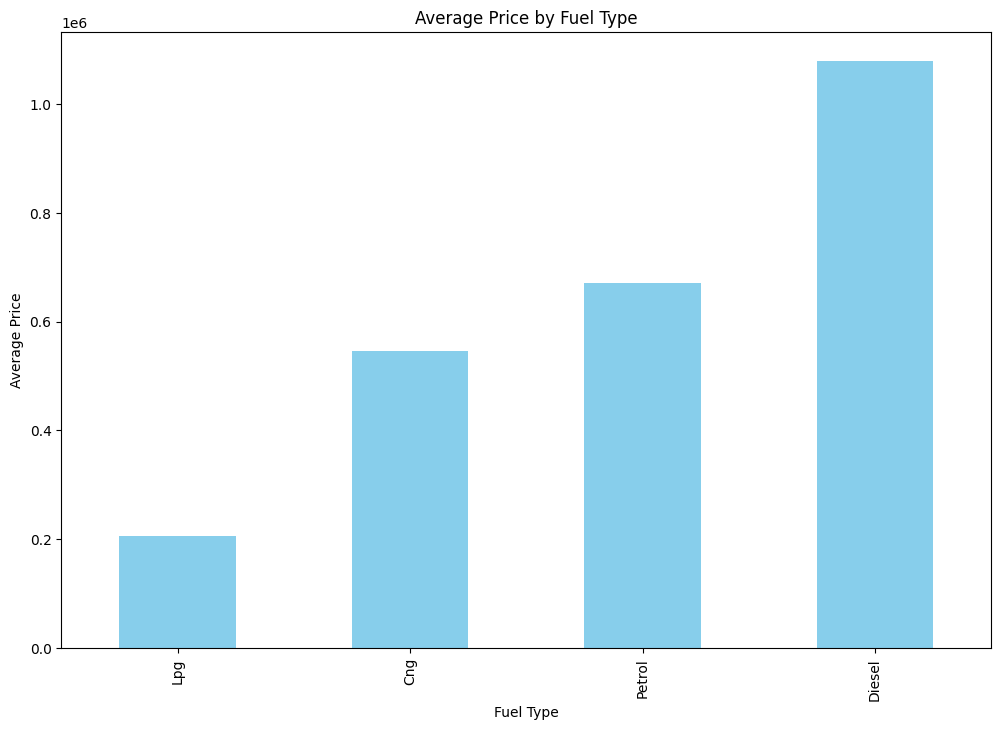

In [46]:
plt.figure(figsize=(12, 8))
average_prices = df_cars_zscore_outlier.groupby('ft')['price'].mean().sort_values()
average_prices.plot(kind='bar', color='skyblue')
plt.xticks(rotation=90)
plt.title('Average Price by Fuel Type')
plt.xlabel('Fuel Type')
plt.ylabel('Average Price')
plt.show()


In [47]:
#combining cng and lpg to gas 
df_cars_zscore_outlier['ft']= df_cars_zscore_outlier['ft'].replace('Cng','Gas')
df_cars_zscore_outlier['ft']= df_cars_zscore_outlier['ft'].replace('Lpg','Gas')

#dropping bt 
df_cars_zscore_outlier.drop(['bt'], axis=1,inplace=True)

## oem, model, and variant name columns

In [48]:
print('Null values(oem):',df_cars_zscore_outlier['oem'].isna().sum())
print('unique elements and its occurance(oem):',df_cars_zscore_outlier['oem'].value_counts())
print('no. of unique elements (oem):',df_cars_zscore_outlier['oem'].nunique())

print('\nNull values(model):',df_cars_zscore_outlier['model'].isna().sum())
print('unique elements and its occurance(model):',df_cars_zscore_outlier['model'].value_counts())
print('no. of unique elements(model):',df_cars_zscore_outlier['model'].nunique())

print('\nNull values(variantName):',df_cars_zscore_outlier['variantName'].isna().sum())
print('unique elements and its occurance(variantName):',df_cars_zscore_outlier['variantName'].value_counts())
print('no. of unique elements(variantName)',df_cars_zscore_outlier['variantName'].nunique())


Null values(oem): 0
unique elements and its occurance(oem): oem
Maruti                2170
Hyundai               1625
Honda                  852
Tata                   408
Mahindra               364
Renault                309
Volkswagen             286
Ford                   283
Toyota                 245
Skoda                  158
Kia                    155
Mercedes-Benz          151
Audi                   129
BMW                    122
Jeep                   108
MG                      83
Nissan                  78
Chevrolet               76
Datsun                  74
Volvo                   37
Fiat                    30
Jaguar                  25
Land Rover              22
Mini                    11
Mitsubishi               9
Citroen                  8
Mahindra Renault         5
Mahindra Ssangyong       4
Lexus                    2
Hindustan Motors         2
Isuzu                    2
Porsche                  1
Name: count, dtype: int64
no. of unique elements (oem): 32

Null values(

## variant type can be dropped as it has many different but can instead use car displacement instead 

In [49]:
df_cars_zscore_outlier = df_cars_zscore_outlier.copy()
df_cars_zscore_outlier.drop(['variantName'], axis=1,inplace=True)

## Can also look to drop columns where car model and brands are less than 0.5% occurance of each unique value

In [50]:
freq_oem = df_cars_zscore_outlier['oem'].value_counts()
freq_model = df_cars_zscore_outlier['model'].value_counts()

# Define threshold
threshold = len(df_cars_zscore_outlier) * 0.005

# Identify categories to keep and filter 
categories_to_keep_oem = freq_oem[freq_oem >= threshold].index
df_cars_zscore_outlier = df_cars_zscore_outlier[df_cars_zscore_outlier['oem'].isin(categories_to_keep_oem)]

categories_to_keep_model= freq_model[freq_model >= threshold].index
df_cars_zscore_outlier = df_cars_zscore_outlier[df_cars_zscore_outlier['model'].isin(categories_to_keep_model)]

df_cars_zscore_outlier.shape


(5822, 21)

# Fuel Supply System Column

In [51]:
print(df_cars_zscore_outlier['Fuel Suppy System'].value_counts())
print(df_cars_zscore_outlier['Fuel Suppy System'].unique())
print(df_cars_zscore_outlier['Fuel Suppy System'].nunique())
print(df_cars_zscore_outlier['Fuel Suppy System'].isna().sum())

Fuel Suppy System
MPFI                                  1797
MPFi                                   688
CRDI                                   543
Direct Injection                       462
CRDi                                   451
PGM-Fi                                 199
PGM - Fi                               156
GDi                                     83
Common Rail                             48
MPI                                     41
MPi                                     37
EFI(Electronic Fuel Injection)          35
MPFI                                    33
EFI (Electronic Fuel Injection)         26
Direct Injection                        25
SEFI                                    20
TSI                                     15
CDI                                     11
Multi Point Fuel Injection               9
PGM-FI (Programmed Fuel Injection)       9
MPFI+LPG                                 6
GDI                                      5
Common Rail Direct Injection (dCi)  

#### We can use transmission and fuel type instead of fuel supply system

In [52]:
df_cars_zscore_outlier.drop('Fuel Suppy System',axis=1,inplace= True)

## Turbo charger and Super Charge

In [53]:
print(df_cars_zscore_outlier['Turbo Charger'].value_counts())
print(df_cars_zscore_outlier['Turbo Charger'].unique())
print(df_cars_zscore_outlier['Turbo Charger'].nunique())
print(df_cars_zscore_outlier['Turbo Charger'].isna().sum())
print('\n',df_cars_zscore_outlier['Super Charger'].value_counts())
print(df_cars_zscore_outlier['Super Charger'].unique())
print(df_cars_zscore_outlier['Super Charger'].nunique())
print(df_cars_zscore_outlier['Super Charger'].isna().sum())

Turbo Charger
No     3475
Yes    1548
NO       20
yes       1
Name: count, dtype: int64
['No' 'Yes' 'NO' nan 'yes']
4
778

 Super Charger
No    4635
Name: count, dtype: int64
['No' nan]
1
1187


In [54]:
mapping = {
    'No':False,
    'NO':False,
    'no':False,
    None:False,

    'Yes':True,
    'YES':True,
    'yes':True,
    'Turbo':True,
    'Twin':True,
}
df_cars_zscore_outlier['Turbo Charger'] = df_cars_zscore_outlier['Turbo Charger'].map(mapping).fillna(False)

print(df_cars_zscore_outlier['Turbo Charger'].value_counts())
print(df_cars_zscore_outlier['Turbo Charger'].unique())
print(df_cars_zscore_outlier['Turbo Charger'].nunique())
print(df_cars_zscore_outlier['Turbo Charger'].isna().sum())
print(df_cars_zscore_outlier['Turbo Charger'].dtype)



Turbo Charger
False    4273
True     1549
Name: count, dtype: int64
[False  True]
2
0
bool


C:\Users\Siva\AppData\Local\Temp\ipykernel_31216\493925833.py:13: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cars_zscore_outlier['Turbo Charger'] = df_cars_zscore_outlier['Turbo Charger'].map(mapping).fillna(False)


In [55]:
mapping = {
    'No':False,
    'NO':False,
    'no':False,

    'Yes':True,
    
}
df_cars_zscore_outlier['Super Charger'] = df_cars_zscore_outlier['Super Charger'].map(mapping).fillna(False)

print(df_cars_zscore_outlier['Super Charger'].value_counts())
print(df_cars_zscore_outlier['Super Charger'].unique())
print(df_cars_zscore_outlier['Super Charger'].nunique())
print(df_cars_zscore_outlier['Super Charger'].isna().sum())
print(df_cars_zscore_outlier['Super Charger'].dtype)



Super Charger
False    5822
Name: count, dtype: int64
[False]
1
0
bool


C:\Users\Siva\AppData\Local\Temp\ipykernel_31216\1354746950.py:9: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_cars_zscore_outlier['Super Charger'] = df_cars_zscore_outlier['Super Charger'].map(mapping).fillna(False)


In [56]:
##Can drop Super Charger as there is huge discrepenc
df_cars_zscore_outlier.drop('Super Charger',axis=1,inplace= True)

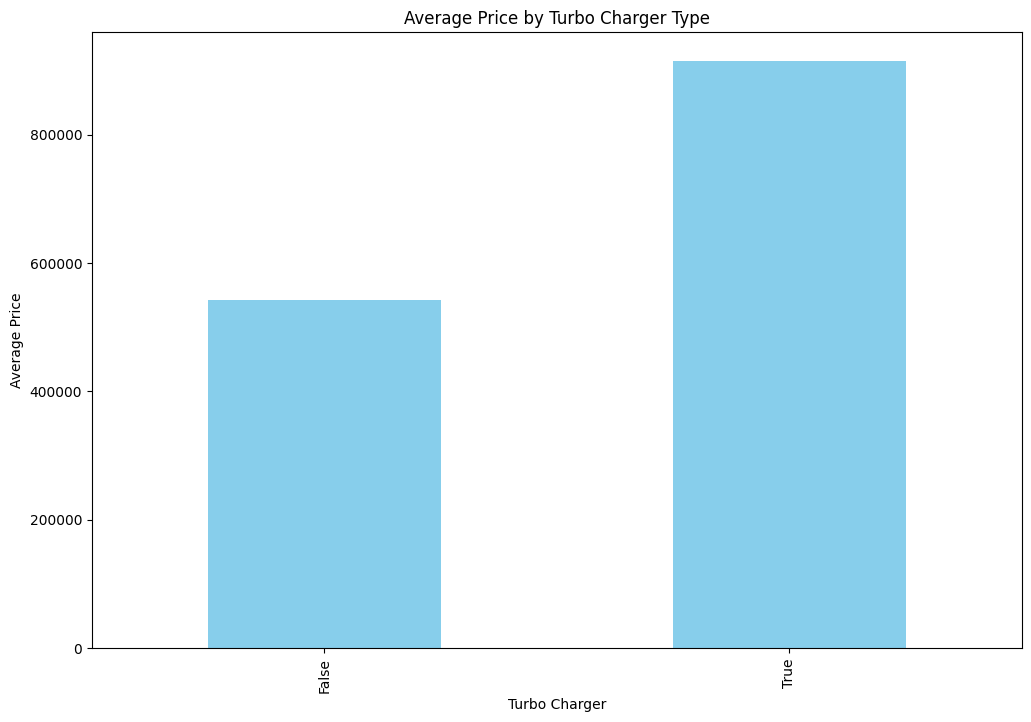

In [57]:
plt.figure(figsize=(12, 8))
average_prices = df_cars_zscore_outlier.groupby('Turbo Charger')['price'].mean().sort_values()
average_prices.plot(kind='bar', color='skyblue')
plt.xticks(rotation=90)
plt.title('Average Price by Turbo Charger Type')
plt.xlabel('Turbo Charger')
plt.ylabel('Average Price')
plt.show()


### can keep this column as there is a resonable difference 

## Gear Box column

In [58]:
print(df_cars_zscore_outlier['Gear Box'].value_counts())
print(df_cars_zscore_outlier['Gear Box'].nunique())
print(df_cars_zscore_outlier['Gear Box'].unique())
print(df_cars_zscore_outlier['Gear Box'].isna().sum())

Gear Box
5 Speed                                   3579
6 Speed                                    702
5-Speed                                    397
5 Speed                                    151
CVT                                        137
6-Speed                                    125
6 Speed                                    108
4 Speed                                    103
7 Speed                                     91
5                                           84
5 Speed CVT                                 43
5 speed                                     35
6-speed                                     31
9 Speed                                     30
7-Speed DCT                                 24
7 Speed DCT                                 16
7-Speed                                     15
4 Speed                                     11
6 Speed IMT                                 10
AGS                                          9
4-Speed                                      9
IVT 

### We can use the automatic and manual for our calculation instead of gearbox

In [59]:
df_cars_zscore_outlier.drop('Gear Box',axis=1,inplace= True)

## Drive Type Column

In [60]:
df_cars_zscore_outlier['Drive Type'] = df_cars_zscore_outlier['Drive Type'].replace({
    # Front-Wheel Drive
    'FWD': 'Front-Wheel Drive (FWD)',
    'FWD ': 'Front-Wheel Drive (FWD)',
    'Front Wheel Drive': 'Front-Wheel Drive (FWD)',
    
    # Rear-Wheel Drive
    'RWD': 'Rear-Wheel Drive (RWD)',
    'Rear Wheel Drive with ESP': 'Rear-Wheel Drive (RWD)',
    'RWD(with MTT)': 'Rear-Wheel Drive (RWD)',
    
    # All-Wheel Drive
    'AWD': 'All-Wheel Drive (AWD)',
    'All Wheel Drive': 'All-Wheel Drive (AWD)',
    'Permanent all-wheel drive quattro': 'All-Wheel Drive (AWD)',
    'AWD INTEGRATED MANAGEMENT': 'All-Wheel Drive (AWD)',
    
    # Four-Wheel Drive
    '4WD': 'Four-Wheel Drive (4WD)',
    '4 WD': 'Four-Wheel Drive (4WD)',
    '4X4': 'Four-Wheel Drive (4WD)',
    '4x4': 'Four-Wheel Drive (4WD)',
    
    # Two-Wheel Drive
    '2WD': 'Front-Wheel Drive (FWD)',
    '2WD ': 'Front-Wheel Drive (FWD)',
    '2 WD': 'Front-Wheel Drive (FWD)',
    '4X2': 'Two-Wheel Drive (2WD)',
    '4x2': 'Two-Wheel Drive (2WD)',
    'Two Wheel Drive': 'Two-Wheel Drive (2WD)',
    
   })

df_cars_zscore_outlier['Drive Type']=df_cars_zscore_outlier['Drive Type'].fillna('Undefined')
print(df_cars_zscore_outlier['Drive Type'].value_counts())
print(df_cars_zscore_outlier['Drive Type'].isna().sum())

Drive Type
Front-Wheel Drive (FWD)    4574
Undefined                   984
Rear-Wheel Drive (RWD)      122
Two-Wheel Drive (2WD)        93
All-Wheel Drive (AWD)        30
Four-Wheel Drive (4WD)       19
Name: count, dtype: int64
0


In [61]:
#Can look to drop this as majority is FWD with undefined next
df_cars_zscore_outlier.drop('Drive Type',axis=1,inplace= True)

## Steering Type Column

In [62]:
print(df_cars_zscore_outlier['Steering Type'].value_counts())
print(df_cars_zscore_outlier['Steering Type'].nunique())
print(df_cars_zscore_outlier['Steering Type'].unique())
print(df_cars_zscore_outlier['Steering Type'].isna().sum())


Steering Type
Power         4443
Electric      1065
Electronic      43
Electrical      40
power           29
Manual          29
EPAS             9
Name: count, dtype: int64
7
['Power' 'power' 'Electric' nan 'EPAS' 'Electrical' 'Electronic' 'Manual']
164


In [63]:
df_cars_zscore_outlier['Steering Type'] = df_cars_zscore_outlier['Steering Type'].replace({
    # Combined Power Systems
    'Power': 'Power',
    'power': 'Power',
    'Electric': 'Power',
    'electric': 'Power',
    'Electronic': 'Power', 
    'Electrical': 'Power', 
    'EPAS': 'Power',
    # Specific Steering Types
    'Manual': 'Manual',
    
})
print(df_cars_zscore_outlier['Steering Type'].value_counts())


Steering Type
Power     5629
Manual      29
Name: count, dtype: int64


In [64]:
## can drop this too since Power is extremely manjor among them
df_cars_zscore_outlier.drop('Steering Type',axis=1,inplace= True)

### Front Brake and rear brake Type Column

In [65]:
print(df_cars_zscore_outlier['Front Brake Type'].value_counts())
print(df_cars_zscore_outlier['Front Brake Type'].nunique())
print(df_cars_zscore_outlier['Front Brake Type'].unique())
print('\n',df_cars_zscore_outlier['Rear Brake Type'].value_counts())
print(df_cars_zscore_outlier['Rear Brake Type'].nunique())
print(df_cars_zscore_outlier['Rear Brake Type'].unique())

Front Brake Type
Disc                   3820
Ventilated Disc        1726
Disc                     67
Solid Disc               63
Disc & Caliper Type      40
Ventilated Discs         32
Disk                     23
Ventilated Disc          10
Ventilated Disk          10
Ventlated Disc            6
Vantilated Disc           5
ABS                       1
Ventilated disc           1
Name: count, dtype: int64
13
['Ventilated Disc' 'Disc' 'Disc ' 'Disc & Caliper Type' 'Ventilated Discs'
 'Ventilated Disc ' nan 'Solid Disc' 'Disk' 'Ventilated Disk'
 'Vantilated Disc' 'ABS' 'Ventlated Disc' 'Ventilated disc']

 Rear Brake Type
Drum                     5256
Disc                      375
Discs                      82
Disc & Caliper Type        40
Solid Disc                 21
Leading-Trailing Drum      17
Disc & Drum                 7
Drum                        6
Name: count, dtype: int64
8
['Drum' 'Discs' 'Disc & Caliper Type' 'Disc' 'Leading-Trailing Drum' nan
 'Solid Disc' 'Disc & Drum' 'Drum

### Given that we have only a small number of instances for Drum (4) and ABS (1), and the rest are predominantly Disc (over 90%), it might be reasonable to consider dropping this column. The small number of instances for Drum and ABS suggests that they may not provide significant predictive power for your model. For the rear brake type, there is considered difference of occurence between drum and disc which may not be producing much effectiveness for our model

In [66]:
df_cars_zscore_outlier.drop(['Front Brake Type','Rear Brake Type'],axis=1,inplace= True)

### Tyre Type Column

In [67]:
print(df_cars_zscore_outlier['Tyre Type'].value_counts())
print(df_cars_zscore_outlier['Tyre Type'].nunique())
print(df_cars_zscore_outlier['Tyre Type'].unique())

Tyre Type
Tubeless,Radial           2805
Tubeless, Radial          1046
Tubeless                  1028
Tubeless Tyres             371
Radial, Tubeless           179
Radial                     106
Radial, Tubless             82
Tubeless Tyres, Radial      54
Tubeless Radial Tyres       50
Tubeless,Radial             43
tubeless tyre               14
Radial,Tubeless              5
Radial Tubeless              4
Tubeless Tyre                2
Name: count, dtype: int64
14
['Tubeless, Radial' 'Tubeless,Radial' 'Tubeless' 'Radial, Tubless'
 'Radial' 'Tubeless,Radial ' 'Radial, Tubeless' 'Tubeless Radial Tyres'
 'Tubeless Tyres' 'Radial,Tubeless' nan 'Tubeless Tyres, Radial'
 'Radial Tubeless' 'tubeless tyre' 'Tubeless Tyre']


In [68]:
## can drop this since most of the values are only tubless, radials

df_cars_zscore_outlier.drop('Tyre Type',axis=1,inplace= True)

In [69]:
df_cars_zscore_outlier.head()

,ft,km,transmission,oem,model,modelYear,price,Insurance Validity,Color,Displacement,Turbo Charger,Location,RTO_grouped
0,Petrol,120000.0,Manual,Maruti,Maruti Celerio,2015,400000.0,Third Party,White,998.0,False,Bangalore,Karnataka
1,Petrol,32706.0,Manual,Ford,Ford Ecosport,2018,811000.0,Comprehensive,White,1497.0,False,Bangalore,Karnataka
2,Petrol,11949.0,Manual,Tata,Tata Tiago,2018,585000.0,Comprehensive,Red,1199.0,False,Bangalore,Karnataka
3,Petrol,17794.0,Manual,Hyundai,Hyundai Xcent,2014,462000.0,Comprehensive,Other,1197.0,False,Bangalore,Karnataka
5,Diesel,20000.0,Manual,Jeep,Jeep Compass,2020,1900000.0,Third Party,Other,1956.0,True,Bangalore,Karnataka


In [70]:
## saving this file as an excel for further use

df_cars_zscore_outlier.to_excel('all_cities_cars_cleaned.xlsx', index=False)


## 4. Model Training 

In [71]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error


df_cars_final = pd.read_excel('all_cities_cars_cleaned.xlsx')

categorical_features = df_cars_final.select_dtypes(include=['object']).columns
numerical_features = df_cars_final.select_dtypes(include=['number']).columns

# Separate the target variable
X = df_cars_final.drop('price', axis=1)
y = df_cars_final['price']

# Apply one-hot encoding to categorical features
X_encoded = pd.get_dummies(X, columns=categorical_features, drop_first=True)

# The numerical columns are automatically included as they are

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

print(f"Training feature set shape: {X_train.shape}")
print(f"Testing feature set shape: {X_test.shape}")


Training feature set shape: (4657, 101)
Testing feature set shape: (1165, 101)


In [72]:
# Define the models
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor(),
    'XGBoost': XGBRegressor()
}

# Store the results
results = {}

# Evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred) * 100
    
    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred) * 100
    
    # Store the results
    results[model_name] = {
        'MSE_train': mse_train,
        'MAE_train': mae_train,
        'R2_train': r2_train,
        'MAPE_train': mape_train,
        'MSE_test': mse_test,
        'MAE_test':mae_test,
        'R2_test': r2_test,
        'MAPE_test': mape_test
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)


                      MSE_train     MAE_train  R2_train  MAPE_train  \
Linear Regression  2.295161e+10  87901.635144  0.865656   17.568229   
Decision Tree      2.584969e+07    391.954763  0.999849    0.096235   
Random Forest      1.403753e+09  24263.194586  0.991783    4.385529   
XGBoost            1.757675e+09  30933.544515  0.989712    5.985480   

                       MSE_test      MAE_test   R2_test  MAPE_test  
Linear Regression  2.851935e+10  95204.333329  0.864272  18.694767  
Decision Tree      1.856908e+10  82503.195708  0.911627  14.911511  
Random Forest      1.074700e+10  64899.745346  0.948853  11.849885  
XGBoost            1.054168e+10  63518.957098  0.949830  11.353159  


## The best models are Random Forrest and XGBoost with R2 scores as 0.9488 and 0.9498

### Attempting to hypertune the parameters 

In [73]:
# For Random Forest

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_distributions_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

rf_model = RandomForestRegressor(random_state=42)
rf_random_search = RandomizedSearchCV(
    rf_model,
    param_distributions=param_distributions_rf,
    n_iter=50,
    scoring='neg_mean_absolute_percentage_error',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

rf_random_search.fit(X_train, y_train)
best_rf_params = rf_random_search.best_params_
print(f"Best Random Forest Parameters: {best_rf_params}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Random Forest Parameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}


In [74]:
# For XGBoost

from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform

param_distributions_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': uniform(0.5, 0.5),
    'colsample_bytree': uniform(0.5, 0.5),
    'alpha': [0, 0.1, 0.5, 1],
    'lambda': [0, 0.1, 0.5, 1]
}

xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
xgb_random_search = RandomizedSearchCV(
    xgb_model,
    param_distributions=param_distributions_xgb,
    n_iter=50,
    scoring='neg_mean_absolute_percentage_error',
    cv=5,
    n_jobs=-1,
    verbose=1,
    random_state=42
)

xgb_random_search.fit(X_train, y_train)
best_xgb_params = xgb_random_search.best_params_
print(f"Best XGBoost Parameters: {best_xgb_params}")


Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best XGBoost Parameters: {'alpha': 1, 'colsample_bytree': 0.8387821809211412, 'lambda': 0.5, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.613247887598969}


In [75]:
# Revaluate with the best parameters 
# Best Random Forest Parameters: 
#{'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': 30}

# Initialize and train the Random Forest model with best parameters
rf_model = RandomForestRegressor(n_estimators=300, 
                                 max_depth=30, 
                                 min_samples_split=2, 
                                 min_samples_leaf=1,
                                 random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions
y_train_pred_rf = rf_model.predict(X_train)

# Calculate metrics for the training set
mse_train_rf = mean_squared_error(y_train, y_train_pred_rf)
r2_train_rf = r2_score(y_train, y_train_pred_rf)
mape_train_rf = mean_absolute_percentage_error(y_train, y_train_pred_rf) * 100

# Print metrics for the training set
print(f"Random Forest Train MSE: {mse_train_rf}")
print(f"Random Forest Train R^2: {r2_train_rf}")
print(f"Random Forest Train MAPE: {mape_train_rf}%")

# Make predictions on the test set
y_test_pred_rf = rf_model.predict(X_test)

# Calculate metrics for the test set
mse_test_rf = mean_squared_error(y_test, y_test_pred_rf)
r2_test_rf = r2_score(y_test, y_test_pred_rf)
mape_test_rf = mean_absolute_percentage_error(y_test, y_test_pred_rf) * 100

# Print metrics for the test set
print(f"Random Forest Test MSE: {mse_test_rf}")
print(f"Random Forest Test R^2: {r2_test_rf}")
print(f"Random Forest Test MAPE: {mape_test_rf}%")

Random Forest Train MSE: 1362282299.765114
Random Forest Train R^2: 0.9920261017962848
Random Forest Train MAPE: 4.332710053696216%
Random Forest Test MSE: 10568033027.238714
Random Forest Test R^2: 0.9497050010936687
Random Forest Test MAPE: 11.820961802529514%


In [76]:
#Best XGBoost Parameters: 
#{'alpha': 1, 'colsample_bytree': 0.8329611783087483, 'lambda': 1, 
#'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 300, 'subsample': 0.7361074625809747}

# Initialize and train the XGBoost model with best parameters
xgb_model = XGBRegressor(alpha=1, 
                         colsample_bytree=0.8329611783087483, 
                         lambda_=1, 
                         learning_rate=0.1, 
                         max_depth=5, 
                         n_estimators=300, 
                         subsample=0.7361074625809747, 
                         objective='reg:squarederror',
                         random_state=42)

xgb_model.fit(X_train, y_train)


# Make predictions
y_train_pred_xgb = xgb_model.predict(X_train)

# Calculate metrics
mse_train_xgb = mean_squared_error(y_train, y_train_pred_xgb)
r2_train_xgb = r2_score(y_train, y_train_pred_xgb)
mape_train_xgb = mean_absolute_percentage_error(y_train, y_train_pred_xgb) * 100

print(f"XGBoost Train MSE: {mse_train_xgb}")
print(f"XGBoost Train R^2: {r2_train_xgb}")
print(f"XGBoost Train MAPE: {mape_train_xgb}%")

# Make predictions
y_test_pred_xgb = xgb_model.predict(X_test)

# Calculate metrics
mse_test_xgb = mean_squared_error(y_test, y_test_pred_xgb)
r2_test_xgb = r2_score(y_test, y_test_pred_xgb)
mape_test_xgb = mean_absolute_percentage_error(y_test, y_test_pred_xgb) * 100

print(f"XGBoost Test MSE: {mse_test_xgb}")
print(f"XGBoost Test R^2: {r2_test_xgb}")
print(f"XGBoost Test MAPE: {mape_test_xgb}%")


c:\Users\Siva\miniconda3\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:03:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0015a694724fa8361-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "lambda_" } are not used.

  warnings.warn(smsg, UserWarning)


XGBoost Train MSE: 2554240026.066942
XGBoost Train R^2: 0.9850491708222119
XGBoost Train MAPE: 7.498532200262044%
XGBoost Test MSE: 8626519496.982498
XGBoost Test R^2: 0.9589449817626522
XGBoost Test MAPE: 11.018322325314733%


### XGBoost Performs the best after best parameters fit  with R2 score of 0.958

## Before finalizing let us utilize Lasso and Ridge regularization to our model to see if performance metrics is better

In [77]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso

models = {
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
}
# Store the results
results = {}

# Evaluate each model
for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Calculate metrics
    mse_train = mean_squared_error(y_train, y_train_pred)
    mae_train = mean_absolute_error(y_train, y_train_pred)
    r2_train = r2_score(y_train, y_train_pred)
    mape_train = mean_absolute_percentage_error(y_train, y_train_pred) * 100
    
    mse_test = mean_squared_error(y_test, y_test_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    r2_test = r2_score(y_test, y_test_pred)
    mape_test = mean_absolute_percentage_error(y_test, y_test_pred) * 100
    
    # Store the results
    results[model_name] = {
        'MSE_train': mse_train,
        'MAE_train': mae_train,
        'R2_train': r2_train,
        'MAPE_train': mape_train,
        'MSE_test': mse_test,
        'MAE_test':mae_test,
        'R2_test': r2_test,
        'MAPE_test': mape_test
    }

# Convert results to DataFrame
results_df = pd.DataFrame(results).T
print(results_df)


                     MSE_train     MAE_train  R2_train  MAPE_train  \
Ridge Regression  2.319858e+10  89019.763404  0.864211   17.813309   
Lasso Regression  2.295172e+10  87907.408342  0.865656   17.569562   

                      MSE_test      MAE_test   R2_test  MAPE_test  
Ridge Regression  2.909239e+10  96268.468197  0.861545  18.958830  
Lasso Regression  2.852785e+10  95210.895093  0.864231  18.695817  


c:\Users\Siva\miniconda3\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 3.363e+13, tolerance: 7.956e+10
  model = cd_fast.enet_coordinate_descent(


### Seems like XGBoost Performs the best and thus we choose that model for the application

# 5. Saving model

In [78]:
import joblib

# Save the model
joblib.dump(xgb_model, 'xgboost_model.pkl')


['xgboost_model.pkl']

In [79]:
# Save column names for encoding
encoded_columns = list(X_encoded.columns)
joblib.dump(encoded_columns, 'encoded_columns.pkl')

['encoded_columns.pkl']

# 6. Saving Car brand images url for display purposes

In [80]:
import pandas as pd
df_cars_final = pd.read_excel('all_cities_cars_cleaned.xlsx')


In [81]:
df_cars_final['url_model'] = ""

In [82]:
df_cars_final['oem'].unique()

array(['Maruti', 'Ford', 'Tata', 'Hyundai', 'Jeep', 'Honda', 'Mahindra',
       'Renault', 'Mercedes-Benz', 'Kia', 'Skoda', 'Volkswagen', 'MG',
       'Toyota', 'Datsun'], dtype=object)

In [83]:
df_cars_final.loc[df_cars_final['oem'] == 'Maruti', 'url_model'] = 'https://logos-world.net/wp-content/uploads/2022/12/Maruti-Suzuki-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Ford', 'url_model'] = 'https://logos-world.net/wp-content/uploads/2021/05/Ford-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Tata','url_model'] = 'https://logos-world.net/wp-content/uploads/2021/11/Tata-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Hyundai','url_model'] = 'https://logos-world.net/wp-content/uploads/2021/03/Hyundai-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Jeep','url_model'] = 'https://logos-world.net/wp-content/uploads/2021/09/Jeep-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Honda','url_model'] = 'https://logos-world.net/wp-content/uploads/2021/03/Honda-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Mahindra','url_model'] = 'https://logos-world.net/wp-content/uploads/2022/12/Mahindra-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Renault','url_model'] = 'https://logos-world.net/wp-content/uploads/2021/04/Renault-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Mercedes-Benz','url_model'] = 'https://logos-world.net/wp-content/uploads/2020/05/Mercedes-Benz-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Kia','url_model'] = 'https://logos-world.net/wp-content/uploads/2021/03/Kia-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Skoda','url_model'] = 'https://logos-world.net/wp-content/uploads/2021/06/Skoda-logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Volkswagen','url_model'] = 'https://logos-world.net/wp-content/uploads/2021/04/Volkswagen-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'MG','url_model'] = 'https://logos-world.net/wp-content/uploads/2021/09/MG-Logo.png'
df_cars_final.loc[df_cars_final['oem'] == 'Toyota','url_model'] = 'https://logos-world.net/wp-content/uploads/2020/04/Toyota-Logo.png'


In [84]:
df_cars_final.to_excel('all_cities_cars_with_url.xlsx', index=False)
